# Project Final Report

**Names:** Ziwangyue Yin, Kevin Li, Zihao Yang, and Kyle Li\
**Section:** 003\
**Group:** 9\
**Date:** _______, 2025

In [1]:
## Necessary Components to Preload

library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# 1. Question

### 1.1 Broad Question

What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

### 1.2 Specific Question

Can a player’s experience, played hours, gender and age be used to accurately predict their newsletter subscription status in players dataset?

# 2. Introduction and Background

### 2.1 Dataset

We chose the players dataset to answer the question.  
There, we first load the data.


In [2]:
url_players <- "https://raw.githubusercontent.com/Sandyyyin/project_final_report/refs/heads/main/players.csv"
players_data <- read_csv(url_players)

players_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


### 2.2 Data Description

<u><b>Overview of Players Dataset:</u></b>
| Dataset | Number of Observations | Number of Variables | Represents |  
|:-----|:---:|:---:|:-----|
| players.csv | 196 | 7 | Data and list of all unique players involved with the server. |

<u><b>Player Dataset:</u></b>

**a) Variables**
| Variable | Type | Short Description |
|:-----|:-----|:-----|
| experience | Character | Self-reported level of experience with Minecraft. This ranged from Amateur -> Reguler -> Veteran -> Pro |
| subscribe | Logical (T/F) | Whether a player had suscribed to a game-related newsletter (yes = True, no = False) |
| hashedEmail | Character | Unique identifier of each player (anonymizing their emails via hashing) |
| played_hours | Numeric (dbl) | Hours spent on the Minecraft server for each participant |
| name | Character | First names (not gamertag) of each individual participating|
| gender | Character | Gender of each individual participating |
| Age | Numeric (dbl) | Age in years of each individual participating |

**b) Summary Statistics**
| Variable | Value (round to 2 decimals if possible) | 
|:-----|:-----:|
| Mean Age | 21.14 |
| Youngest Age | 9 |
| Oldest Age | 58 |
| Standard Deviation of Age | 7.39 | 
| Mean Hours Played | 5.85 |
| Highest Number of Hours Played | 223.1|
| Lowest Number of Hours Played | 0 |
| Standard Deviation of Hours Played | 28.36 | 
| Number of Players | 196 | 
| Proportion Subscribed (%) | 73.47 | 

Note: Since we know that each player (196 total) has a unique identifier and a first name, we also know that the number of hashed emails and names also equal to 196. Furthermore, for the sake of simplicity, we will not be presenting gender or experience proportions in the Summary Statistics table.

# 3. Methods & Results

To answer our specific question, the first thing we need to determine is which method we will use for prediction. For predicting subscription status, we will use the K-nearest neighbors (KNN) classification method.  
The reason for this choice is that classification aims to predict a categorical class for an observation based on its other variables, and in our case, subscription status is a categorical variable.

### 3.1 Wrangling Data

First, we select the response variable (subscribe) and two explanatory variables (gender and age). We noticed that there are “prefer not to say” entries in the gender variable and NA values in the age variable, both of which are uninformative. Therefore, we removed these records.

In [3]:
wrangling_players_data <- players_data |>
    select(subscribe, experience, Age) |>
    filter(!is.na(Age))

Since we will be working with subscribe as a categorical variable, it is a good idea to convert it to a factor type. In addition, because KNN classification uses distances for prediction, it is necessary to convert experience to a numerical type. Here, we assign numerical values to experience based on familiarity levels: beginner (0), amateur (1), regular (2), veteran (3), and pro (4).

In [4]:
wrangling_players_data <- wrangling_players_data |>
    mutate(subscribe = as_factor(subscribe)) |>
    mutate(experience = recode(experience,
                               "Beginner" = "0",
                               "Amateur" = "1",
                               "Regular" = "2",
                               "Veteran" = "3",
                               "Pro" = "4")) |>
    mutate(experience = as.numeric(experience))
wrangling_players_data

subscribe,experience,Age
<fct>,<dbl>,<dbl>
TRUE,4,9
TRUE,3,17
FALSE,3,17
⋮,⋮,⋮
FALSE,3,22
FALSE,1,57
FALSE,1,17


### 3.2 Standarization

Since the classifier predicts classes by identifying the nearest observations, variables with larger scales will have a much greater influence than those with smaller scales. To avoid this issue and improve the accuracy of our model, we need to standardize the variables.

In [5]:
players_data_recipe <- recipe(subscribe ~ ., data = wrangling_players_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    prep()

scaled_players_data <- bake(players_data_recipe, wrangling_players_data)
scaled_players_data

experience,Age,subscribe
<dbl>,<dbl>,<fct>
1.895915,-1.6427185,TRUE
1.073079,-0.5601286,TRUE
1.073079,-0.5601286,FALSE
⋮,⋮,⋮
1.0730793,0.1164900,FALSE
-0.5725917,4.8528206,FALSE
-0.5725917,-0.5601286,FALSE


### 3.3 Visualization

Note: For 3.3.2 and 3.3.3, we visualize via scatter plots of age versus gender and age versus played hours, respectively. The wrangling steps are slightly different from those used for the scatter plot of age versus player’s experience (3.3.1), so we have combined all the steps together instead of listing them separately. Also, keep in mind that for 'Subscription Status', TRUE = subscribed to game-related newsletter and FALSE = not subscribed to the newsletter! 

#### 3.3.1 Visualization Comparing Age Versus Player's Experience Level in Relation to Subscription Status

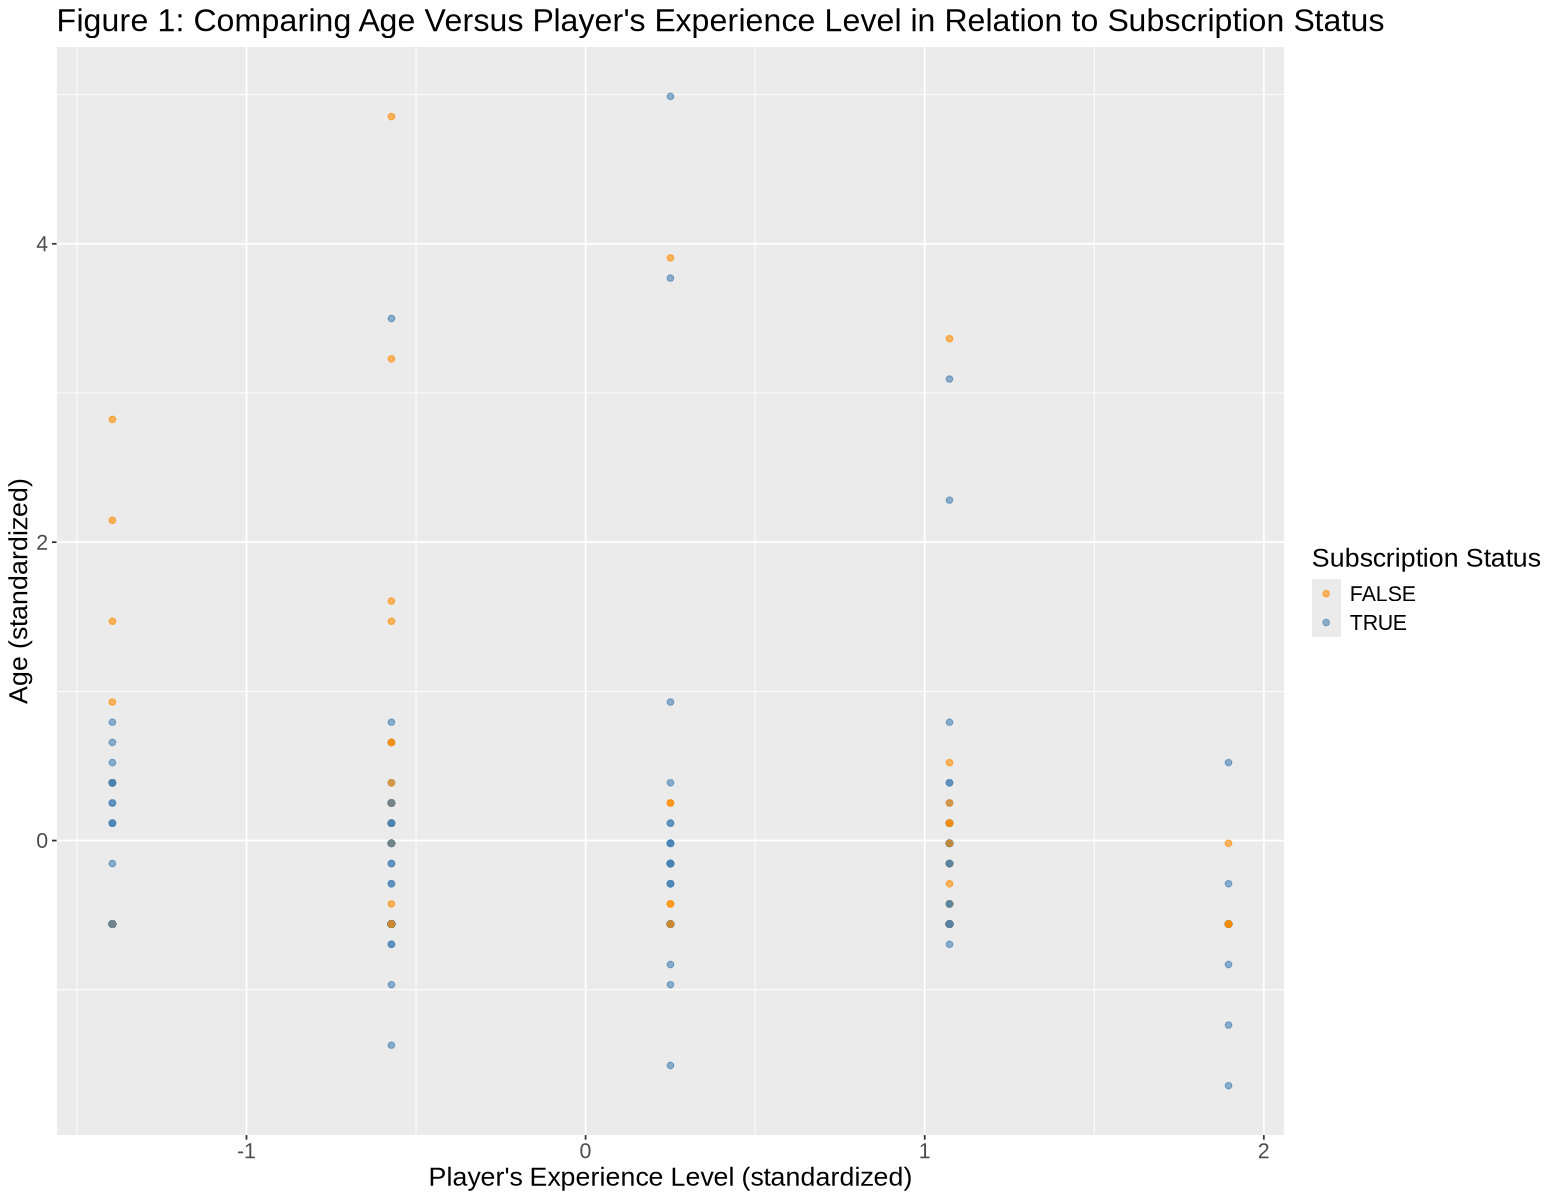

In [9]:
options(repr.plot.width = 13, repr.plot.height = 10) 

experi_age <- scaled_players_data |>
    ggplot(aes(x = experience, y = Age, color = subscribe)) +
    geom_point(alpha = 0.6) +
    labs(x = "Player's Experience Level (standardized)",
         y = "Age (standardized)",
         color = "Subscription Status") +
    scale_color_manual(values = c("darkorange", "steelblue")) +
    theme(text = element_text(size = 16)) +
    ggtitle("Figure 1: Comparing Age Versus Player's Experience Level in Relation to Subscription Status")

experi_age

#### 3.3.2 Visualization Comparing Age Versus Gender in Relation to Subscription Status

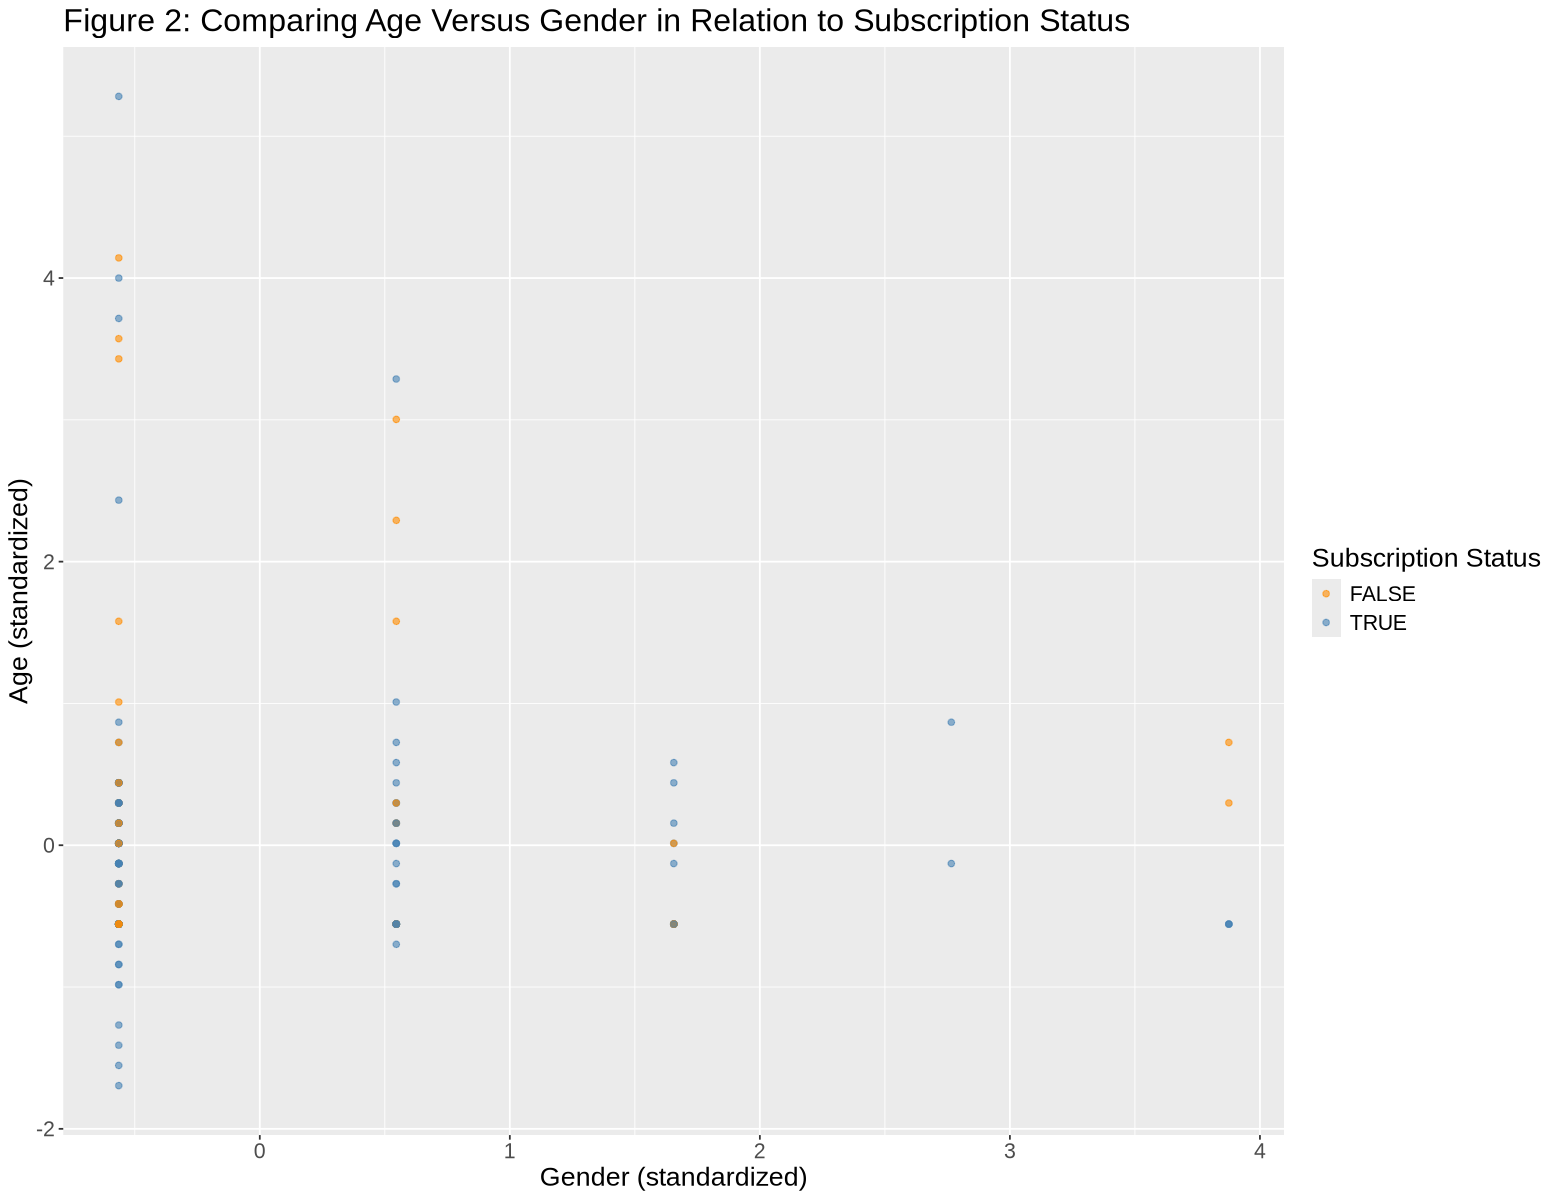

In [7]:
wrangling_players_data_2 <- players_data |>
    select(subscribe, gender, Age) |>
    filter(gender != "Prefer not to say", !is.na(Age))

wrangling_players_data_2 <- wrangling_players_data_2 |>
    mutate(subscribe = as_factor(subscribe)) |>
    mutate(gender = recode(gender,
                           "Male" = "0",
                           "Female" = "1",
                           "Non-binary" = "2",
                           "Agender" = "3",
                           "Two-Spirited" = "4")) |>
    mutate(gender = as.numeric(gender))

players_data_recipe_2 <- recipe(subscribe ~ ., data = wrangling_players_data_2) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    prep()

scaled_players_data_2 <- bake(players_data_recipe_2, wrangling_players_data_2)

options(repr.plot.width = 13, repr.plot.height = 10) 

gender_age <- scaled_players_data_2 |>
    ggplot(aes(x = gender, y = Age, color = subscribe)) +
    geom_point(alpha = 0.6) +
    labs(x = "Gender (standardized)",
         y = "Age (standardized)",
         color = "Subscription Status") +
    scale_color_manual(values = c("darkorange", "steelblue")) +
    theme(text = element_text(size = 16)) +
    ggtitle("Figure 2: Comparing Age Versus Gender in Relation to Subscription Status")

gender_age

#### 3.3.2 Visualization Comparing Age Versus Hours Played in Relation to Subscription Status

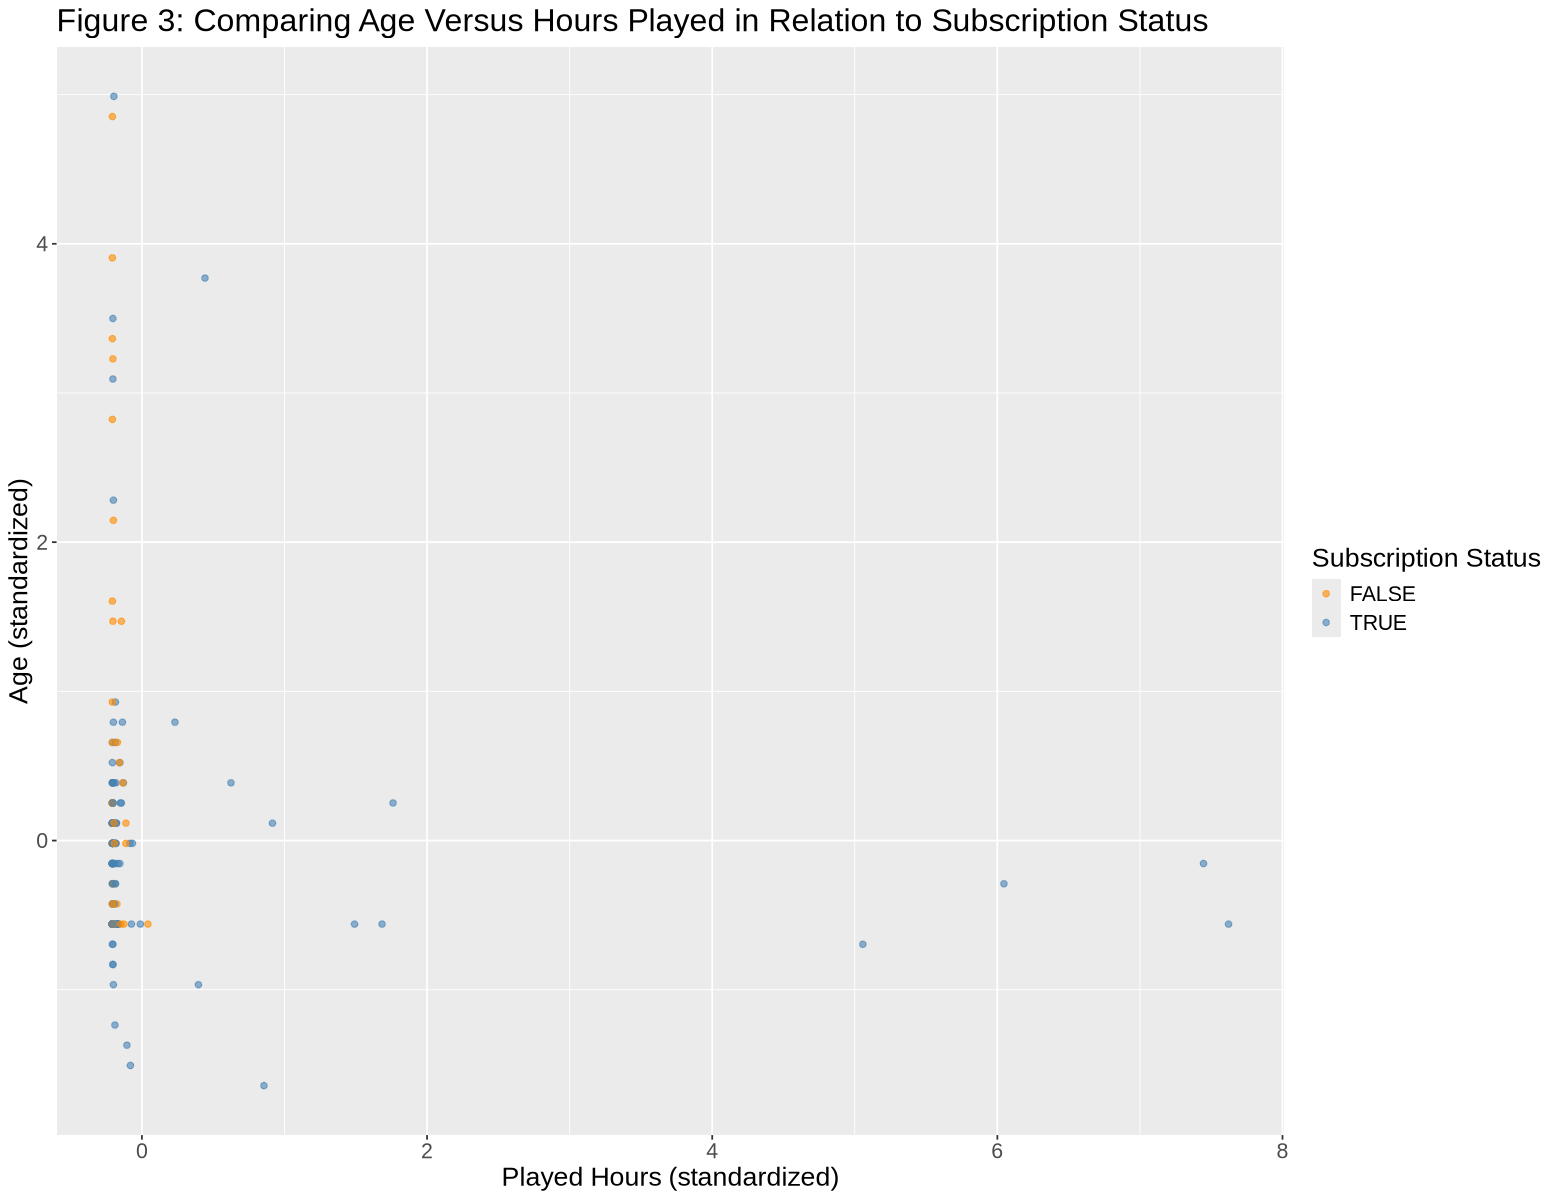

In [8]:
wrangling_players_data_3 <- players_data |>
    select(subscribe, played_hours, Age) |>
    filter(!is.na(Age))

wrangling_players_data_3 <- wrangling_players_data_3 |>
    mutate(subscribe = as_factor(subscribe))

players_data_recipe_3 <- recipe(subscribe ~ ., data = wrangling_players_data_3) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    prep()

scaled_players_data_3 <- bake(players_data_recipe_3, wrangling_players_data_3)

options(repr.plot.width = 13, repr.plot.height = 10) 

hours_age <- scaled_players_data_3 |>
    ggplot(aes(x = played_hours, y = Age, color = subscribe)) +
    geom_point(alpha = 0.6) +
    labs(x = "Played Hours (standardized)",
         y = "Age (standardized)",
         color = "Subscription Status") +
    scale_color_manual(values = c("darkorange", "steelblue")) +
    theme(text = element_text(size = 16)) +
    ggtitle("Figure 3: Comparing Age Versus Hours Played in Relation to Subscription Status")

hours_age

### 3.4 Result

According to the three figures above, age can be used to predict newsletter subscription status in the players dataset with reasonable accuracy. In all three figures, it is evident that younger players tend to subscribe more.  
Based on Figures 1 and 2, since gender and player’s experience were originally non-numerical variables, they might also be useful for predicting newsletter subscription status.  
However, based on Figure 3, most subscription status values (both true and false) are concentrated around 0, suggesting that this variable may not be helpful for prediction.

## 4. Discussion

Requirement:
- summarize what you found
- discuss whether this is what you expected to find
- discuss what impact could such findings have
- discuss what future questions could this lead to

## 5. GitHub Link